## Initialization

In [1]:
# import findspark
import findspark
findspark.init()

# import SparkSession
from pyspark.sql import SparkSession

# create session
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

In [2]:
print(spark)

In [3]:
# read dataset
df = spark.read.csv("epa_co_daily_summary.csv", header=True, inferSchema=True)

In [4]:
# find out dataset's length
df.count()

8064820

In [5]:
# find out attributes
df.head()

Row(state_code=6, county_code=73, site_num=5, parameter_code=42101, poc=1, latitude=33.20265, longitude=-117.365925, datum=u'NAD27', parameter_name=u'Carbon monoxide', sample_duration=u'1 HOUR', pollutant_standard=u'CO 1-hour 1971', date_local=datetime.datetime(1994, 2, 1, 0, 0), units_of_measure=u'Parts per million', event_type=u'None', observation_count=24, observation_percent=100.0, arithmetic_mean=1.129167, first_max_value=1.9, first_max_hour=8, aqi=None, method_code=66, method_name=u'INSTRUMENTAL - NONDISPERSIVE INFRARED', local_site_name=u'Oceanside-Mission Ave', address=u'1701 MISSION AVE. OCEANSIDE', state_name=u'California', county_name=u'San Diego', city_name=u'Oceanside', cbsa_name=u'San Diego-Carlsbad CA', date_of_last_change=datetime.datetime(2016, 4, 27, 0, 0))

In [6]:
# find out each schema
df.schema

StructType(List(StructField(state_code,IntegerType,true),StructField(county_code,IntegerType,true),StructField(site_num,IntegerType,true),StructField(parameter_code,IntegerType,true),StructField(poc,IntegerType,true),StructField(latitude,DoubleType,true),StructField(longitude,DoubleType,true),StructField(datum,StringType,true),StructField(parameter_name,StringType,true),StructField(sample_duration,StringType,true),StructField(pollutant_standard,StringType,true),StructField(date_local,TimestampType,true),StructField(units_of_measure,StringType,true),StructField(event_type,StringType,true),StructField(observation_count,IntegerType,true),StructField(observation_percent,DoubleType,true),StructField(arithmetic_mean,DoubleType,true),StructField(first_max_value,DoubleType,true),StructField(first_max_hour,IntegerType,true),StructField(aqi,IntegerType,true),StructField(method_code,IntegerType,true),StructField(method_name,StringType,true),StructField(local_site_name,StringType,true),StructField

In [7]:
# create alias table to work on as 'trees'
df.createOrReplaceTempView("carbon_monoxide")

## Clustering and Visualization

In [8]:
### 1 menunjukkan daerah yang mempunya aqi diantara 0 dan 50 
carbon = spark.sql("SELECT DISTINCT state_name, latitude, longitude\
                    FROM carbon_monoxide\
                    WHERE aqi between 0 and 50\
                    ORDER BY state_name")
carbon.show()

+----------+---------+-----------+
|state_name| latitude|  longitude|
+----------+---------+-----------+
|   Alabama|33.485556|    -86.915|
|   Alabama|33.503611|   -86.8125|
|   Alabama|   33.515| -86.805556|
|   Alabama|33.565278| -86.796389|
|   Alabama|  30.7703|   -88.0875|
|   Alabama|33.521427| -86.844112|
|   Alabama| 32.40712| -86.256367|
|   Alabama|33.529444| -86.850278|
|   Alabama|33.545556| -86.782778|
|   Alabama| 34.68767|  -86.58637|
|   Alabama|33.553056|    -86.815|
|    Alaska| 64.84569|-147.727413|
|    Alaska|64.844847|-147.723536|
|    Alaska|64.845278|-147.721111|
|    Alaska|   61.115|  -149.8461|
|    Alaska|  61.3267|-149.569707|
|    Alaska|61.195556|-149.902778|
|    Alaska|61.215027|-149.903111|
|    Alaska|61.193889|-149.866667|
|    Alaska|61.219722|-149.895556|
+----------+---------+-----------+
only showing top 20 rows



In [9]:
carbon.count()

1179

In [10]:
# converting latitude and longitude into vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["latitude", "longitude"],
    outputCol='features')

carbon = assembler.transform(carbon)
carbon.show()

+----------+---------+-----------+--------------------+
|state_name| latitude|  longitude|            features|
+----------+---------+-----------+--------------------+
|   Alabama| 34.68767|  -86.58637|[34.68767,-86.58637]|
|   Alabama|33.545556| -86.782778|[33.545556,-86.78...|
|   Alabama|   33.515| -86.805556| [33.515,-86.805556]|
|   Alabama|33.529444| -86.850278|[33.529444,-86.85...|
|   Alabama|33.521427| -86.844112|[33.521427,-86.84...|
|   Alabama| 32.40712| -86.256367|[32.40712,-86.256...|
|   Alabama|33.565278| -86.796389|[33.565278,-86.79...|
|   Alabama|33.485556|    -86.915| [33.485556,-86.915]|
|   Alabama|  30.7703|   -88.0875|  [30.7703,-88.0875]|
|   Alabama|33.503611|   -86.8125|[33.503611,-86.8125]|
|   Alabama|33.553056|    -86.815| [33.553056,-86.815]|
|    Alaska|64.842222|-147.750833|[64.842222,-147.7...|
|    Alaska|   61.115|  -149.8461|  [61.115,-149.8461]|
|    Alaska|61.219722|-149.895556|[61.219722,-149.8...|
|    Alaska|61.215027|-149.903111|[61.215027,-14

In [11]:
# train model to cluster
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(carbon)

In [12]:
predictions = model.transform(carbon)
predictions.show(5)

+----------+---------+----------+--------------------+----------+
|state_name| latitude| longitude|            features|prediction|
+----------+---------+----------+--------------------+----------+
|   Alabama| 34.68767| -86.58637|[34.68767,-86.58637]|         0|
|   Alabama|33.545556|-86.782778|[33.545556,-86.78...|         0|
|   Alabama|   33.515|-86.805556| [33.515,-86.805556]|         0|
|   Alabama|33.529444|-86.850278|[33.529444,-86.85...|         0|
|   Alabama|33.521427|-86.844112|[33.521427,-86.84...|         0|
+----------+---------+----------+--------------------+----------+
only showing top 5 rows



In [13]:
# evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.65688030055


In [14]:
# shows the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 38.29314845 -91.23587824]
[  38.11226238 -115.76383709]
[  62.56341487 -149.06334794]
[ 37.66281281 -77.9915615 ]
[  21.41554167 -158.17987267]


In [15]:
# visualization using pixiedust
import pixiedust

Pixiedust database opened successfully


In [17]:
display(predictions)

# hasil dari cluster


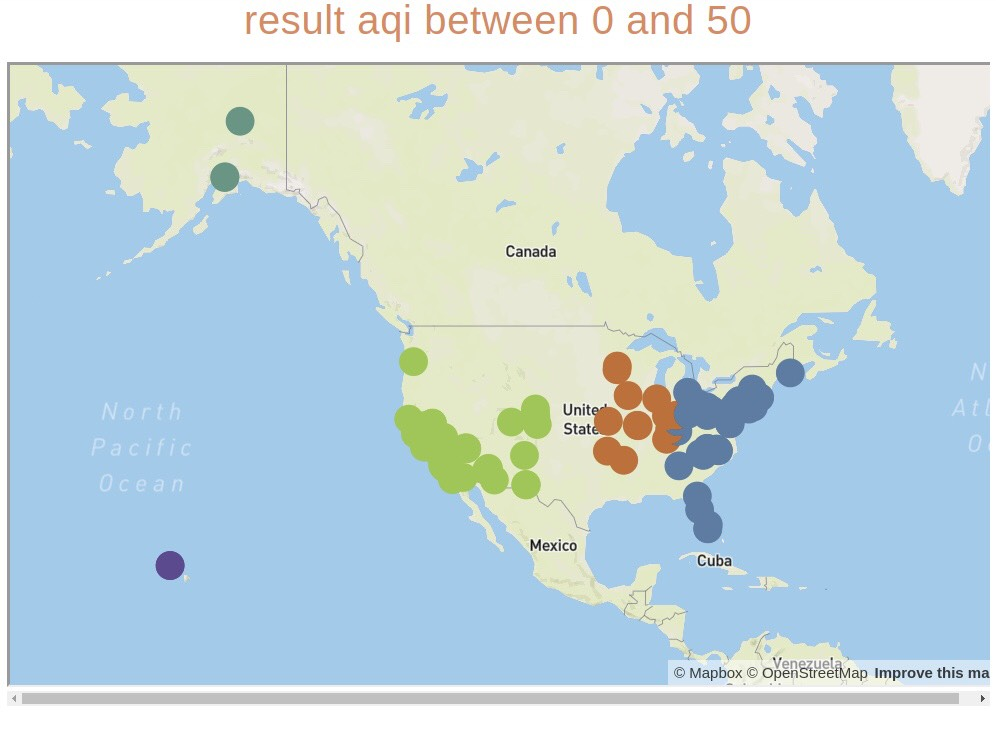

In [22]:
from IPython.display import Image
Image(filename="9545679018588.jpg", width=500,height=500)